In [17]:
import os
import torch
from glob import glob
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timm
from PIL import Image
import numpy as np
import kagglehub

## Configuration

In [18]:
class Config:
    model_name = "efficientnet_b3"
    img_size = 300
    batch_size = 32
    lr = 1e-4
    epochs = 15
    patience = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_split = 0.70
    val_split = 0.15
    test_split = 0.15

    save_dir = "checkpoints"
    os.makedirs(save_dir, exist_ok=True)

CFG = Config()

## Transform & Dataset Class

In [19]:
train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

class ChestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [20]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

DATA_DIR = f"{path}/chest_xray/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

normal_imgs = glob(TEST_DIR + "/NORMAL/*.jpeg") + glob(TRAIN_DIR + "/NORMAL/*.jpeg") + glob(VAL_DIR + "/NORMAL/*.jpeg")
pneumonia_imgs = glob(TEST_DIR + "/PNEUMONIA/*.jpeg") + glob(TRAIN_DIR + "/PNEUMONIA/*.jpeg") + glob(VAL_DIR + "/PNEUMONIA/*.jpeg")

all_images = normal_imgs + pneumonia_imgs
labels = [0]*len(normal_imgs) + [1]*len(pneumonia_imgs)

print(f"Total normal images: {len(normal_imgs)}")
print(f"Total pneumonia images: {len(pneumonia_imgs)}")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Total normal images: 1583
Total pneumonia images: 4273


In [21]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    all_images, labels, test_size=CFG.test_split, stratify=labels, random_state=42
)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    train_imgs, train_labels, test_size=CFG.val_split/(1-CFG.val_split), stratify=train_labels, random_state=42
)

print("Train:", len(train_imgs))
print("Val:", len(val_imgs))
print("Test:", len(test_imgs))

Train: 4098
Val: 879
Test: 879


## DataLoaders with WeightedRandomSampler

In [22]:
# Using sample weights to handle imbalanced class
class_counts = [labels.count(0), labels.count(1)]  # Normal, Pneumonia
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [weights[label] for label in train_labels]

sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

train_data = ChestDataset(train_imgs, train_labels, transform=train_tf)
val_data   = ChestDataset(val_imgs, val_labels, transform=test_tf)
test_data  = ChestDataset(test_imgs, test_labels, transform=test_tf)

train_loader = DataLoader(train_data, batch_size=CFG.batch_size, sampler=sampler)
val_loader   = DataLoader(val_data, batch_size=CFG.batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=CFG.batch_size, shuffle=False)

## EfficientNet-B3 Model

In [23]:
model = timm.create_model(
    CFG.model_name,
    pretrained=True,
    num_classes=2
).to(CFG.device)

criterion = nn.CrossEntropyLoss(weight=weights.to(CFG.device))
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

## Training Model

In [24]:
from tqdm.notebook import tqdm
import numpy as np

best_val_loss = np.inf
patience_counter = 0
best_model_path = f"{CFG.save_dir}/{CFG.model_name}_best.pt"

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc" : []
}

def train_epoch():
    model.train()
    total_loss, correct = 0.0, 0

    for imgs, labels in tqdm(train_loader, desc="Train", leave=False, total=len(train_loader)):
        imgs = imgs.to(CFG.device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=CFG.device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss/len(train_loader), correct/len(train_data)


def validate():
    model.eval()
    total_loss, correct = 0.0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Val", leave=False, total=len(val_loader)):
            imgs = imgs.to(CFG.device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=CFG.device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss/len(val_loader), correct/len(val_data)


for epoch in range(CFG.epochs):
    print(f"\nEpoch {epoch+1}/{CFG.epochs}")
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate()

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}  |  Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}  |  Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(">>> Saved best model!")
    else:
        patience_counter += 1
        if patience_counter >= CFG.patience:
            print(">>> Early stopping triggered!")
            break


Epoch 1/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2438  |  Acc: 0.9087
Val   Loss: 0.2908  |  Acc: 0.9124
>>> Saved best model!

Epoch 2/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1372  |  Acc: 0.9497
Val   Loss: 0.2241  |  Acc: 0.9363
>>> Saved best model!

Epoch 3/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1147  |  Acc: 0.9578
Val   Loss: 0.2463  |  Acc: 0.9272

Epoch 4/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0642  |  Acc: 0.9736
Val   Loss: 0.1791  |  Acc: 0.9374
>>> Saved best model!

Epoch 5/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0739  |  Acc: 0.9776
Val   Loss: 0.1681  |  Acc: 0.9534
>>> Saved best model!

Epoch 6/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0541  |  Acc: 0.9790
Val   Loss: 0.1892  |  Acc: 0.9681

Epoch 7/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0411  |  Acc: 0.9837
Val   Loss: 0.1618  |  Acc: 0.9590
>>> Saved best model!

Epoch 8/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0402  |  Acc: 0.9839
Val   Loss: 0.2008  |  Acc: 0.9488

Epoch 9/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0348  |  Acc: 0.9832
Val   Loss: 0.1804  |  Acc: 0.9625

Epoch 10/15


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0247  |  Acc: 0.9890
Val   Loss: 0.1805  |  Acc: 0.9659
>>> Early stopping triggered!


## Plot Loss & Training Curves

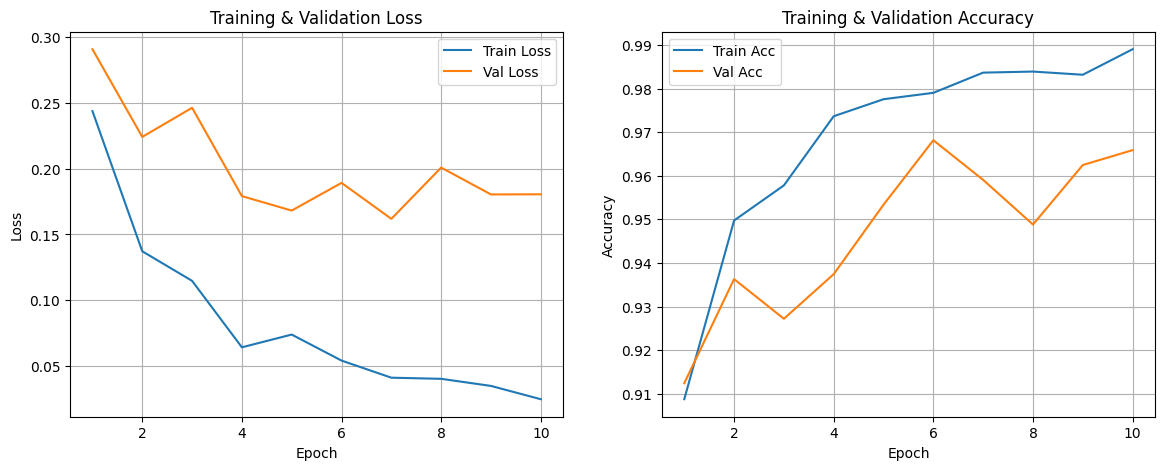

In [25]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

## Model Evaluation

In [26]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(CFG.device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)
        probs_batch = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        all_probs.extend(probs_batch)

## Confusion Matrix + Classification Report + ROC-AUC

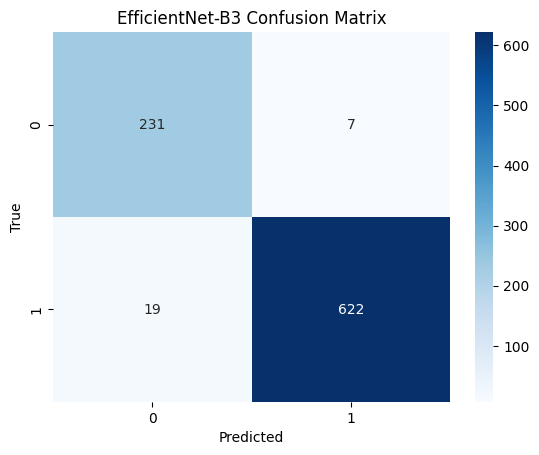

              precision    recall  f1-score   support

      Normal       0.92      0.97      0.95       238
   Pneumonia       0.99      0.97      0.98       641

    accuracy                           0.97       879
   macro avg       0.96      0.97      0.96       879
weighted avg       0.97      0.97      0.97       879



In [27]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet-B3 Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))

ROC AUC Score: 0.9965


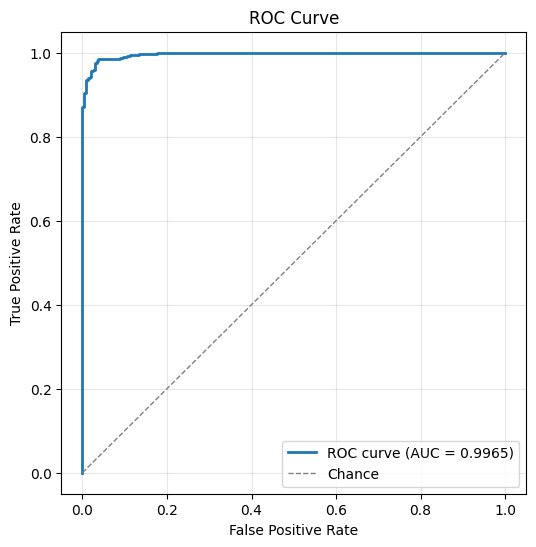

In [28]:
# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs, pos_label=1)
auc_score = roc_auc_score(all_labels, all_probs)

# print AUC and plot ROC
print(f"ROC AUC Score: {auc_score:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="C0", lw=2, label=f"ROC curve (AUC = {auc_score:.4f})")
plt.plot([0,1], [0,1], color="gray", lw=1, linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()